# Ejercicio 2

Para esta seccion, seleccionamos de nuevo el corpus **cess_es** y lo preprocesamos de la misma manera que en el ejercicio 1

In [1]:
import re
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math   

from preprocesador import *
from subword import *
from frecuencias import *

os.environ["NLTK_DATA"]="datos_nltk/"
import  nltk
from nltk.corpus import stopwords

## Paso 1
Preprocesamos el corpus

In [2]:
## Seleccionamos el corpus
from nltk.corpus import cess_esp

nltk.download("cess_esp")

## Obtenemos las oraciones del corpus para el entrenamiento de nuestra red neuronal
corpus_sents = cess_esp.sents()[0:1000]

print("Numero de oraciones en el corpus:", len(corpus_sents))

[nltk_data] Downloading package cess_esp to /home/joel/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


Numero de oraciones en el corpus: 1000


In [3]:
# Procedemos a normalizar el texto:
nltk.download('stopwords')
stopwords_list = stopwords.words('spanish')

# Normalizamos los oraciones
sents_norm = [pre_procesar(oracion, stopwords_list) for oracion in corpus_sents]
# Obtenemos todas las palabras del texto
tokens_normalizados = [x for xs in sents_norm for x in xs]

print("Numero de tokens, despues del preprocesamiento:", len(tokens_normalizados))

[nltk_data] Downloading package stopwords to /home/joel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Numero de tokens, despues del preprocesamiento: 17801


In [4]:
# Entrenamos nuestro algoritmo de BPE con las palabras del corpus, 
# obtenemos las reglas y las frecuencias de cada token
freqs_bpe, reglas_bpe = entrenar_byte_pair_encoding(tokens_normalizados, 500)

In [5]:
# Aplicamos nuestro modelo bpe a cada oracion para obtener las oraciones tokenizadas
sents_tokenizadas = [aplicar_bpe(sent, reglas_bpe) for sent in sents_norm]

# Agregamos la etiqueta <BOS> a cada oracion
sents_tokenizadas = [["<BOS>"] + sent for sent in sents_tokenizadas]


In [6]:
# Construimos la tabla para las frecuencias de las palabras
tabla_frecuencias_bpe = crear_tabla_frecuencias(freqs_bpe)
print(tabla_frecuencias_bpe)

         palabra  frecuencia
0             de         523
1              a         432
2              o         429
3             to         334
4             do         289
...          ...         ...
4226   lazarocar           1
4227  realidades           1
4228       queri           1
4229       fatal           1
4230       pleta           1

[4231 rows x 2 columns]


In [7]:
#Convertimos la tabla en un diccionario para usarlo en el modelo
palabras = tabla_frecuencias_bpe['palabra']
frecuencias = tabla_frecuencias_bpe['frecuencia']
dic_palabras = {}  
for i in range(len(frecuencias)):
    dic_palabras[palabras[i]] = frecuencias[i]
dic_palabras["<BOS>"] = len(sents_norm)
dic_palabras["<EOS>"] = len(sents_norm)

In [8]:
ETIQUETA_UNK = "<UNK>"
def indices_palabras(palabras_frecuencias: dict):
    """Calcula los indices de las palabras dadas sus frecuencias

    Parameters
    ----------
    palabras_frecuencias : dict
        Diccionario donde las llaves son las palabras y los valores sus frecuencias

    Returns
    -------
    dict,dict
        Diccionarios uno a uno de palabras a indices y viceversa
    """
    result = {}
    for ind, palabra in enumerate(palabras_frecuencias.keys()):
        # Ocurrio un Happax legomena o singleton
        if palabras_frecuencias[palabra] == 1:
            # Indice temporal para UNK
            result[ETIQUETA_UNK] = len(palabras_frecuencias)
        else:
            result[palabra] = ind

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [9]:
#Se obtienen los índices de cada palabra
palabras_a_indices, indices_a_palabras = indices_palabras(dic_palabras)
print(palabras_a_indices)
print(indices_a_palabras)
len(palabras_a_indices)

{'de': 0, 'a': 1, 'o': 2, 'to': 3, 'do': 4, 'co': 5, 'con': 6, 're': 7, 'ta': 8, 'c': 9, 'i': 10, 'ca': 11, 'ti': 12, 'te': 13, 'e': 14, 'en': 15, 'al': 16, 'es': 17, 'cia': 18, 'l': 19, 'fi': 20, 'da': 21, 'si': 22, 'di': 23, 'ex': 24, 'd': 25, 'mo': 26, 'z': 27, 'pe': 28, 's': 29, 'li': 30, 'h': 31, '2': 32, 'os': 33, 'hoy': 34, 'f': 35, '1': 36, 'se': 37, 'on': 38, 't': 39, 'p': 40, 'g': 41, 'le': 42, 'pro': 43, 'ci': 44, 'dos': 45, 'k': 46, 'gi': 47, 'ra': 48, 'bi': 49, 'in': 50, 'tar': 51, 'mi': 52, 'que': 53, 'r': 54, 'pi': 55, 'ar': 56, 'ri': 57, 'gobierno': 58, 'vi': 59, 'su': 60, '4': 61, 'y': 62, 'presidente': 63, 'ce': 64, '6': 65, 'car': 66, 'tas': 67, 'an': 68, 'b': 69, 'des': 70, 'tos': 71, 'go': 72, 'por': 73, '3': 74, 'hi': 75, 'u': 76, 'as': 77, 'com': 78, 'tes': 79, 'er': 80, 'ro': 81, 'dad': 82, 'ter': 83, 'la': 84, 'fe': 85, 'ento': 86, 'vo': 87, '7': 88, 've': 89, '0': 90, 'no': 91, 'ni': 92, 'cion': 93, 'zo': 94, 'cu': 95, 'so': 96, 'me': 97, 'ver': 98, 'per': 99,

2593

In [10]:
def get_id(palabra_a_id: dict, palabra: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK

    Parameters
    ----------
    palabra_a_id : dict
        Diccionario de palabras a indices
    palabra : str
        Palabra a buscar

    Returns
    -------
    int
        Indice de la palabra
    """
    id_unknow = palabra_a_id[ETIQUETA_UNK]
    return palabra_a_id.get(palabra, id_unknow)

In [11]:
def lista_indices(corpus:list, palabras_a_indices:dict) -> list:
    """Genera una lista de indices que representan las palabras de un corpus 
    Parameters
    ----------
    corpus : list
        corpus a procesar
    indices_a_palabras : dict
        Diccionario de palabras a indices
    Returns
    -------
    list
        Lista de indices que representan las palabras del corpus
    """
    indices = []
    for sent in corpus:
        renglon = []
        for token in sent:
            renglon.append(get_id(palabras_a_indices, token))
        indices.append(renglon)
    return indices

In [12]:
def lista_siguientes(entradas : list) -> list:
    """
    Genera una lista de palabras siguientes a partir de una lista de palabras.
    Parameters
    ----------
    entradas : list
        lista de listas de palabras, donde cada lista tiene 
        como primer elemento la etiqueta <BOS>.
    Returns
    -------
    list
        Lista de listas donde cada palabra es la palabra que le sigue 
        en la entrada, o la etiqueta <EOS> si es la última de la lista.
    """
    salidas = []
    for sent in entradas:
        renglon = []
        for i in range(len(sent)-1):
            renglon.append(sent[i+1])    
        renglon.append("<EOS>")                
        salidas.append(renglon)
    return(salidas)

In [13]:
#Obtenemos los índices de cada oración
indices_sents = lista_indices(sents_tokenizadas, palabras_a_indices)
print(indices_sents[0])
print(sents_tokenizadas[0])

[2591, 270, 17, 1437, 919, 175, 44, 13, 0, 191, 64, 14, 25, 35, 519, 34, 159, 241, 78, 970, 117, 36, 147, 293, 742, 336, 919, 175, 44, 2590, 2590, 16, 801, 48, 14, 1, 1, 151, 737, 2338, 52, 39, 2339, 75, 249, 2340, 1475, 102, 145, 1216, 917, 61, 123, 117, 97, 129, 1650]
['<BOS>', 'grupo', 'es', 'tatal', 'elec', 'tri', 'ci', 'te', 'de', 'fran', 'ce', 'e', 'd', 'f', 'anuncio', 'hoy', 'jue', 'ves', 'com', 'pra', '5', '1', 'porciento', 'empresa', 'mexi', 'cana', 'elec', 'tri', 'ci', 'dadagui', 'lade', 'al', 'tami', 'ra', 'e', 'a', 'a', 'cre', 'ada', 'japones', 'mi', 't', 'subis', 'hi', 'cor', 'poration', 'poneren', 'mar', 'cha', 'central', 'gas', '4', '9', '5', 'me', 'ga', 'vatios']


In [14]:
#Obtenemos las palabras siguientes y sus índices que se usarán para el entrenamiento 
siguientes_tokenizadas = lista_siguientes(sents_tokenizadas)
indices_siguientes = lista_indices(siguientes_tokenizadas, palabras_a_indices)

print(siguientes_tokenizadas[0])
print(indices_siguientes[0])

['grupo', 'es', 'tatal', 'elec', 'tri', 'ci', 'te', 'de', 'fran', 'ce', 'e', 'd', 'f', 'anuncio', 'hoy', 'jue', 'ves', 'com', 'pra', '5', '1', 'porciento', 'empresa', 'mexi', 'cana', 'elec', 'tri', 'ci', 'dadagui', 'lade', 'al', 'tami', 'ra', 'e', 'a', 'a', 'cre', 'ada', 'japones', 'mi', 't', 'subis', 'hi', 'cor', 'poration', 'poneren', 'mar', 'cha', 'central', 'gas', '4', '9', '5', 'me', 'ga', 'vatios', '<EOS>']
[270, 17, 1437, 919, 175, 44, 13, 0, 191, 64, 14, 25, 35, 519, 34, 159, 241, 78, 970, 117, 36, 147, 293, 742, 336, 919, 175, 44, 2590, 2590, 16, 801, 48, 14, 1, 1, 151, 737, 2338, 52, 39, 2339, 75, 249, 2340, 1475, 102, 145, 1216, 917, 61, 123, 117, 97, 129, 1650, 2592]


## Paso 2 
Construimos la red neuronal recurrente usando pytorch y el módulo RNN

In [15]:
import torch    
import torch.nn as nn

In [16]:
class RecurrentNetwork(nn.Module):
    def __init__(self, dim_in, dim_out, dim=100, dim_h=200):
        super().__init__()
        #Capa de embedding
        self.emb = nn.Embedding(dim_in,dim)
        #Capa de RNN (bidireccional)
        self.recurrence = nn.RNN(dim, dim_h, bidirectional=True)
        #Capa lineal
        lineal = nn.Linear(2*dim_h,dim_out)
        #Activacion
        pre = nn.Softmax(dim=2)
        #Salida
        self.ffw = nn.Sequential(lineal, pre)
        
    def forward(self, x):
        #Se convierte en tensor
        x = torch.tensor(x)
        #Embedding
        x = self.emb(x)
        x = x.unsqueeze(1)
        #Capas recurrentes
        h, c = self.recurrence(x)
        #Activación
        h = h.tanh()
        #Salida
        y_pred = self.ffw(h)
        y_pred = y_pred.transpose(1, 2)
        return y_pred

    def get_emb(self):
        return self.emb

In [62]:
#Se crea la red recurrente
#Numero de iteraciones
EPOCHS = 10
#Taza de aprendizaje
LEARNING_RATE = 0.005
#Dimension
dim = 2

#Se crea la red
rnn = RecurrentNetwork(len(indices_a_palabras.keys()), len(indices_a_palabras.keys()))

#Se definen los conjuntos de entradas y salidas
x = indices_sents
y = indices_siguientes

#Se define la función de riesgo y el optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(rnn.parameters(), LEARNING_RATE)

In [63]:
%%time

losses = []
#Se entrena el modelo
for epoch in range(EPOCHS):
    for x_i, y_i in zip(x, y):
        #Forward
        y_pred = rnn(x_i)

        #Backward
        y_i = (torch.tensor(y_i)).unsqueeze(1)

        #Se calcula el eror
        loss = criterion(y_pred, y_i)

        #Reiniciamos los gradientes a cero
        optimizer.zero_grad(set_to_none=True)
        #Backpropagation
        loss.backward()
        #Actualizamos parametros
        optimizer.step()

    losses.append(loss.detach().numpy())
    print(f"Epoch={epoch}. Training loss={loss}")


Epoch=0. Training loss=7.787203311920166
Epoch=1. Training loss=7.787115573883057
Epoch=2. Training loss=7.787091255187988
Epoch=3. Training loss=7.787038803100586
Epoch=4. Training loss=7.787113666534424
Epoch=5. Training loss=7.78704833984375
Epoch=6. Training loss=7.7870259284973145
Epoch=7. Training loss=7.787024021148682
Epoch=8. Training loss=7.787008762359619
Epoch=9. Training loss=7.787010669708252
CPU times: user 18min 51s, sys: 1min 33s, total: 20min 24s
Wall time: 5min 49s


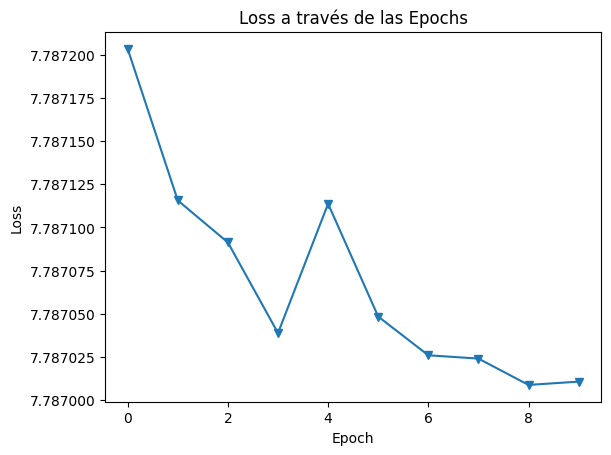

In [64]:
#Graficamos los diferentes losses a través de las iteraciones
plt.plot(losses, 'v-')
plt.title('Loss a través de las Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [65]:
def get_valor(tupla : tuple) -> any:
    """Obtiene el valor de una tupla con al menos 2 valores"""
    return tupla[1]

def get_proba(corpus_eval : list, palabras_a_ind : dict, sort_func) -> list:
    """
    Obtiene las probabilidades de cada palabra en corpus_eval ordenadas según el criterio de sort_func.
    Parameters
    ----------
    corpus_eval : list
        lista de cadenas de las cuáles se obtendrán sus probabilidades.
    palabras_a_ind : dict
        Diccionario de palabras a indices.
    sort_func : any
        Función que indica sobre qué criterio debe ordenarse las probabilidades.
    Returns
    -------
    list
        Lista de listas donde se guardan las probabilidades de cada palabra.
    """
    probas = []
    ind_corpus = [palabras_a_ind[w] for w in corpus_eval]
    output = rnn(ind_corpus)
    for i in range(len(corpus_eval)):
        renglon = []
        for j in range(len(palabras_a_ind.keys())):
            palabras = list(palabras_a_ind.keys())
            valor = output[i][j].item()
            renglon.append((palabras[j], valor))
        renglon.sort(key=sort_func, reverse=True)
        probas.append(renglon)
    return probas


In [66]:
#Obtenemos las probabilidades para unos tokens de ejemplo, ordenadas de mayor a menor.
prueba = ["<BOS>", "grupo", "es", "tatal", "<EOS>"]
probas = get_proba(prueba, palabras_a_indices, get_valor)
for p in range(len(probas)):
    print(f"Probas para {prueba[p]}")
    for proba in probas[p][0:10]:
        print(proba)
    print("")

Probas para <BOS>
('re', 0.31881341338157654)
('o', 0.13702110946178436)
('ci', 0.11123760789632797)
('<UNK>', 0.09205446392297745)
('<EOS>', 0.08523744344711304)
('d', 0.08273228257894516)
('ti', 0.0413951650261879)
('i', 0.034419093281030655)
('ta', 0.024651307612657547)
('f', 0.017684049904346466)

Probas para grupo
('i', 0.26870396733283997)
('o', 0.24747619032859802)
('do', 0.24342669546604156)
('<EOS>', 0.057493120431900024)
('ti', 0.05470217764377594)
('to', 0.03694572299718857)
('re', 0.028537532314658165)
('a', 0.018209392204880714)
('de', 0.01734447292983532)
('ra', 0.008981162682175636)

Probas para es
('<EOS>', 0.6039010882377625)
('i', 0.14722007513046265)
('ra', 0.06976377218961716)
('d', 0.04083064943552017)
('ti', 0.03775492310523987)
('<UNK>', 0.02033180743455887)
('a', 0.018425198271870613)
('ta', 0.01830669865012169)
('e', 0.017529327422380447)
('do', 0.014999757520854473)

Probas para tatal
('<EOS>', 0.9360567331314087)
('o', 0.023871514946222305)
('a', 0.0118895983

## Paso 3: 
Evaluamos el modelo usando perplejidad

In [67]:
def get_perplexity(corpus_eval : list, palabras_a_ind : dict) -> float:
    """
    Obtiene el valor de perplejidad de la red con las palabras en corpus_eval
    ----------
    corpus_eval : list
        lista de cadenas de las cuáles se obtendrá el valor de perplejidad.
    palabras_a_ind : dict
        Diccionario de palabras a indices.
    Returns
    -------
    float
        Valor de perplejidad de las palabras.
    """
    perplexity = 0
    indices_corpus = []
    for token in corpus_eval:
        if token in palabras_a_ind.keys():
            indices_corpus.append(palabras_a_ind[token])
        else:
            indices_corpus.append(palabras_a_ind["<UNK>"])
            
    output = rnn(indices_corpus)
    probas = []
    for i in range(len(output)-1):
        probas.append(output[i][indices_corpus[i+1]].item())

    for p in probas:
        if(perplexity != 0):
            perplexity != 1/p
        else:
            perplexity = 1/p
    return perplexity ** (1/(len(corpus_eval)-2))

In [76]:
#Probando la perplejidad con tokens del corpus
evaluacion = ["<BOS>", "grupo", "es", "tatal", "<EOS>"]
perplejidad = get_perplexity(evaluacion, palabras_a_indices)
print(f"Perplejidad de la oración: {perplejidad}")

Perplejidad de la oración: 558.5201940327134


In [79]:
#Probando la perplejidad con tokens en desorden
evaluacion = ["<EOS>", "tatal", "a", "grupo"]
perplejidad = get_perplexity(evaluacion, palabras_a_indices)
print(f"Perplejidad de la oración: {perplejidad}")

Perplejidad de la oración: 48.08213124005273


## Paso 4 
Usando el modelo generamos una cadena aleatoria

In [80]:
import random
def generate_words(palabras_a_ind: dict, size: int, n : int) -> str:
    """
    Genera una oración de longitud size con los tokens más probables según la red recurrente.
    Cada token es elegido aleatoriamente de entre los n con mayor probabilidad, si n es mayor
    a la longitud del vocabulario se elige de entre todos los tokens posibles.
    Parameters
    ----------
    palabras_a_ind : dict
        Diccionario de palabras a indices.
    size : int
        Número de palabras a generar.
    n : int
        La cantidad de tókens más probables a elegir.
    Returns
    -------
    list
        Lista de listas donde se guardan las probabilidades de cada palabra.
    """
    oracion = ""
    ultima = "<BOS>"
    for i in range(size):
        result = get_proba([ultima], palabras_a_ind, get_valor)
        siguiente = "<UNK>"
        ind = random.randint(0, min(n, len(result[0])-1))
        while siguiente == "<UNK>": #Se vuelve a elegir si toca un UNK
            siguiente = result[0][ind][0]
            ind = random.randint(0, min(n, len(result[0])-1))
        if(siguiente == "<EOS>"):
            oracion += ". "
        elif(siguiente != "<BOS>"):
            oracion += f"{siguiente} "
        ultima = siguiente
    return oracion

In [82]:
#Generamos la cadena
print("Generando cadena: ")
print(generate_words(palabras_a_indices, 10, 10))

Generando cadena: 
i al . dialogo de i al tami de re 


## Paso 5 
Visualizamos los embbedings

In [83]:
#Obtenemos todos los embbedings de la red recurrente
last_ind = len(list(indices_a_palabras.keys()))
last_emb = torch.tensor(list(range(last_ind)))

emb_list = []
for ind in indices_a_palabras.keys():
    emb_vector = rnn.emb(last_emb).detach().numpy()[ind]
    emb_list.append(emb_vector)

#Visualizamos uno de los embbedings
palabra_emb = "grupo"
print(f"Word: {palabra_emb} \nEmbedding:\n {emb_list[palabras_a_indices[palabra_emb]]}")


Word: grupo 
Embedding:
 [-0.92565966  0.19261712 -1.0122026   1.2461778  -0.61773294  0.40076587
  0.46872637 -0.4940368  -0.8428053  -0.85507345  0.7934729   0.34914124
  0.10098731  0.8416071  -1.4895381   0.24347563 -0.18346146 -0.36041218
 -2.6309538   1.2917362   0.34555742  0.36116415 -0.5454006   0.6721968
 -1.5013926   0.42002207 -0.07812162  0.774       0.9650753  -0.77398574
 -0.5785439  -1.2033619   0.9765214   0.6137517   0.43496603 -1.1058327
 -1.8759181   0.2977091  -0.7079929  -0.799563    0.8347486  -0.6846085
  1.0849648   1.0279186   1.285775   -1.2826648  -0.96238154  1.2894236
 -0.710781   -0.66151977  1.8041478   0.20791283  1.6786429   0.49140254
  0.1411287  -0.28657576 -0.4473764  -0.26783913  0.10283068  0.99324876
  0.44957253 -0.03533294  0.18740101 -0.7174388   0.62161595 -0.55839336
  0.8466191  -0.10953798 -1.1904831  -0.72358763  0.40865478 -1.1700811
  1.457385   -0.5845872   1.1966714  -1.3885293  -0.3822314  -0.6784713
 -0.7140715   0.38941014 -0.3551

In [84]:
#Obtenemos los primeros dos valores de cada emmbeding para obtener vectores bidimensionales
two_emb = []
for emb in emb_list:
    elem = [e for e in emb[0:2]]
    two_emb.append(elem)

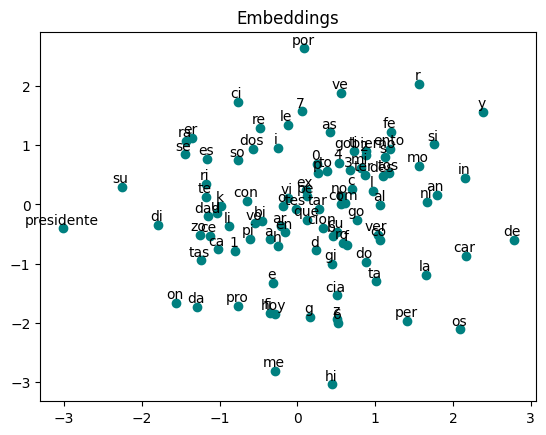

In [85]:
#Graficamos los embbedings bidimensionales
def plot_words(Z, ids):
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='teal')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

plot_words(np.array(two_emb)[0:100], list(palabras_a_indices.keys()))
plt.title('Embeddings')
plt.show()